In [109]:
import math
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from astral import Observer
from astral.sun import sun
from pytz import timezone
from timezonefinder import TimezoneFinder
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
def validate_df(df):
    assert 'date' in df.columns
    assert 'time' in df.columns
    assert 'lat' in df.columns
    assert 'lng' in df.columns
    assert 'subject_race' in df.columns

In [3]:
def time_to_mins(time):    
    # Return nan if time is nan
    if time != time:
        return time
    
    # Return time in mins
    mins = int(time.hour * 60 + time.minute + time.second / 60)
    return mins

In [4]:
def clean_df(df):
    df['date'] = pd.to_datetime(df['date'])
    if isinstance(df.time.values[0], str):
        df['time'] = pd.to_datetime(df.time).dt.time
    return df

In [5]:
def filter_for_intertwilight_zone(df):
    """Assumes dusk & time are column names in df.
    """
    earliest_dusk = df.dusk.min()
    latest_dusk = df.dusk.max()
    result = df[df.time >= earliest_dusk].copy()
    result = result[result.time <= latest_dusk]
    return result

In [6]:
def black_white_stops_only(df):
    """Stanford OPP only compares black vs white stops."""
    df = df.copy()
    is_black = df.subject_race == 'black'
    is_white = df.subject_race == 'white'
    return df[np.logical_or(is_black, is_white)]

In [7]:
def remove_grey_area_stops(df):
    """Remove stops that occurred after sun started setting and before sun finally vanishing.
    It's not clear whether it's light out or dark out, so OPP removes these stops.
    
    Assumes sunset, dusk, and time are columns in df.
    
    Notes: It probably isn't necessary to remove these stops. You could model 'lighting' as a
    continuous value in [0, 1], instead of as a boolean. You get more data, but you do have to
    assume that the ability to racial profile is linear with the amount of lighting.
    """
    after_sunset = df.sunset < df.time
    before_dusk = df.time < df.dusk
    df = df[~np.logical_and(after_sunset, before_dusk)].copy()
    return df

In [8]:
def get_sunset_df(stops_df):
    """Return a dataframe where each row is a unique date and the columns denote 
    the sunset & dusk time for that date
    """
    dates = pd.to_datetime(stops_df['date']).unique()
    center_lat, center_lng = stops_df['lat'].mean(), stops_df['lng'].mean()
    tf = TimezoneFinder()
    tz_name = tf.timezone_at(lng=center_lng, lat=center_lat)
    tz = timezone(tz_name)
    city = Observer(center_lat, center_lng)
    suns = np.array([sun(city, pd.Timestamp(date), tzinfo=tz) for date in dates])
    sunsets = np.array([sun['sunset'].time() for sun in suns])
    dusks = np.array([sun['dusk'].time() for sun in suns])
    sunset_df = pd.DataFrame({'date': dates, 'sunset': sunsets, 'dusk': dusks})
    return sunset_df

In [9]:
def add_mutations(df):
    """Add columns like sunset, dusk, is_dark, time_mins, is_black, is_white."""
    sunset_df = get_sunset_df(df)
    df = df.merge(sunset_df, on='date')
    df['time_mins'] = df.time.apply(time_to_mins)
    df['time_mins'] = pd.to_numeric(df.time_mins, errors='coerce')
    df['is_dark'] = df['time'] > df['dusk']
    df['is_black'] = (df.subject_race == 'black').astype(int)
    df['is_white'] = (df.subject_race == 'white').astype(int)
    
    # Bin time into 15-minute intervals
    n_bins = (df.time_mins.max() - df.time_mins.min()) / 15
    df = df[df.time_mins.notna()]
    df['time_bins'] = pd.cut(df['time_mins'], int(n_bins))
    df['time_bins'] = [str(round(v.left)) for v in df['time_bins'].values]
    return df

In [10]:
def preprocess(df):
    df = df.copy()
    df = clean_df(df)
    df = black_white_stops_only(df)
    df = add_mutations(df)
    df = filter_for_intertwilight_zone(df)
    df = remove_grey_area_stops(df)
    return df

In [185]:
def veil_of_darkness_model(df, skip_preprocess=False):
    if not skip_preprocess:
        df = preprocess(df)
    mod = smf.glm(formula='is_black ~ is_dark + time_bins + district + subject_sex + subject_age', 
              family=sm.families.Binomial(),
              data=df)
    mod = mod.fit()
    return mod

In [186]:
def veil_of_darkness_results(df, skip_preprocess=False):
    """Return tuple (p value of racial profiling, increased likelihood of being stopped bc black)."""
    mod = veil_of_darkness_model(df, skip_preprocess)
    p_val = mod.pvalues['is_dark[T.True]']
    increased_odds = np.exp(mod.params)['is_dark[T.True]']
    n_sig_digits = 5
    return round(p_val, n_sig_digits), round(1 - increased_odds, n_sig_digits)

In [190]:
# summarize sf
sf = pd.read_csv('../data/raw_data/san_francisco.csv', low_memory=False)
mod = veil_of_darkness_model(sf)
print(mod.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               is_black   No. Observations:                93780
Model:                            GLM   Df Residuals:                    93749
Model Family:                Binomial   Df Model:                           30
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47657.
Date:                Mon, 19 Jul 2021   Deviance:                       95313.
Time:                        23:33:11   Pearson chi2:                 9.41e+04
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.3028    

In [65]:
veil_of_darkness_results(sf)

(0.0, 0.08434)

In [211]:
def sample_n(df, M=250, n=100):
    """Stratify sample black & white stops"""
    
    pval_lst = []
    odds_lst = []
    df = preprocess(df.copy())
    black = df[df['is_black'] == 1]
    white = df[df['is_white'] == 1]
    frac_white = len(white.index) / len(df.index)
    n_white = (int) (frac_white * n)
    n_black = (int) ((1 - frac_white) * n)

    for i in range(M):
        sampled_white = white.sample(n_white)
        sampled_black = black.sample(n_black)
        sampled = pd.concat([sampled_white, sampled_black], axis=0)
        pval, odds = veil_of_darkness_results(sampled, skip_preprocess=True)
        pval_lst.append(pval)
        odds_lst.append(odds)
    return pval_lst, odds_lst

In [90]:
avg_yearly = df['date'].dt.year.value_counts().mean()
sfpd_size = 1869
lapd_size = 32
n_hat = int(avg_yearly * lapd_size / sfpd_size)
n_hat

171

In [208]:
n_white

70239

In [209]:
n_black

29926

In [210]:
frac_white

0.7012329656067489

In [172]:
lapd_size / sfpd_size

0.017121455323702513

In [173]:
avg_yearly

10016.5

In [94]:
n_hat

171

In [118]:
len(sf.index)

905070

In [212]:
pvalues, _ = sample_n(sf, 100, n_hat)
frac = sum([p < .1 for p in pvalues]) / len(pvalues)

In [215]:
frac

0.1

In [119]:
fracs = []
for n in range(10000, 100000, 10000):
    pvalues, _ = sample_n(sf, 75, n)
    frac = sum([p < .1 for p in pvalues]) / len(pvalues)
    fracs.append(frac)

In [200]:
print(fracs)

[0.17333333333333334, 0.16, 0.25333333333333335, 0.30666666666666664, 0.22666666666666666, 0.29333333333333333, 0.37333333333333335, 0.44, 0.4266666666666667]


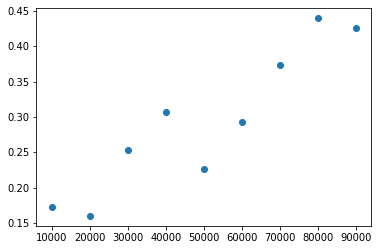

In [122]:
plt.scatter(range(10000, 100000, 10000), fracs)

In [124]:
sf.subject_race.value_counts()

white                     372318
asian/pacific islander    157684
black                     152196
hispanic                  116014
other                     106858
Name: subject_race, dtype: int64

In [133]:
df

,raw_row_number,date,time,location,lat,lng,district,subject_age,subject_race,subject_sex,...,reason_for_stop,raw_search_vehicle_description,raw_result_of_contact_description,sunset,dusk,time_mins,is_dark,is_black,is_white,time_bins
62,870075,2014-08-01,17:32:00,SILVER AVE & MADRID ST,37.728565,-122.427611,NaN,NaN,white,female,...,Mechanical or Non-Moving Violation (V.C.),No Search,Citation,20:17:56.679932,20:47:30.286907,1052.0,False,0,1,1045
63,870076,2014-08-01,17:40:00,FORESTER & HEARST,37.730697,-122.448889,NaN,NaN,white,female,...,Mechanical or Non-Moving Violation (V.C.),No Search,Citation,20:17:56.679932,20:47:30.286907,1060.0,False,0,1,1045
64,870083,2014-08-01,18:23:00,26TH AVE & OCEAN AVE,37.732448,-122.481894,NaN,NaN,white,female,...,Moving Violation,No Search,Warning,20:17:56.679932,20:47:30.286907,1103.0,False,0,1,1091
65,870085,2014-08-01,18:30:00,KEITH & SHAFTER,37.729998,-122.388886,NaN,NaN,white,male,...,Moving Violation,No Search,Warning,20:17:56.679932,20:47:30.286907,1110.0,False,0,1,1106
66,870086,2014-08-01,18:35:00,3RD ST & SHAFTER AVE,37.731643,-122.391910,NaN,NaN,black,female,...,Mechanical or Non-Moving Violation (V.C.),No Search,Citation,20:17:56.679932,20:47:30.286907,1115.0,False,1,0,1106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524481,892945,2014-10-31,20:10:00,30TH AND JUDAH ST,37.760934,-122.489113,NaN,NaN,white,male,...,Moving Violation,No Search,Warning,18:11:45.473546,18:39:23.722824,1210.0,True,0,1,1197
524482,892946,2014-10-31,20:15:00,LAKE ST & 12TH AVE,37.786395,-122.471136,NaN,NaN,white,male,...,Moving Violation,No Search,Citation,18:11:45.473546,18:39:23.722824,1215.0,True,0,1,1212
524483,892950,2014-10-31,20:38:00,JEFFERSON ST & MASON ST,37.808428,-122.414188,NaN,NaN,white,male,...,Moving Violation,No Search,Citation,18:11:45.473546,18:39:23.722824,1238.0,True,0,1,1227
524484,892954,2014-10-31,20:54:00,JERROLD AVENUE & PHELPS STREET,37.739862,-122.391287,NaN,NaN,white,male,...,Mechanical or Non-Moving Violation (V.C.),No Search,Citation,18:11:45.473546,18:39:23.722824,1254.0,True,0,1,1242


(array([12091., 13783., 10914., 12932., 10203., 10889.,  8450.,  8721.,
         5873.,  6309.]),
 array([1041. , 1063.6, 1086.2, 1108.8, 1131.4, 1154. , 1176.6, 1199.2,
        1221.8, 1244.4, 1267. ]),
 <BarContainer object of 10 artists>)

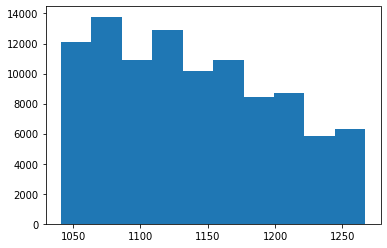

In [135]:
plt.hist(df.time_mins)

In [140]:
len(sf.index)

905070

In [162]:
df.date.dt.year.max()

2016

In [151]:
sf.subject_race

0         asian/pacific islander
1                          black
2                       hispanic
3                       hispanic
4                          white
                   ...          
905065                     white
905066    asian/pacific islander
905067                     white
905068                     black
905069                     white
Name: subject_race, Length: 905070, dtype: object

In [152]:
(sf.subject_race.isin(('white', 'black', 'asian/pacific islander')) == True).sum() / len(sf.index)

0.7537516435192858

In [139]:
len(df.index) / 524514

0.1909672573086705